In [1]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Random number generation
import random

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 
import seaborn as sns

# Deep learning
import tensorflow as tf 

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import losses

In [2]:
def create_X_Y_generalized(ts: np.array, n_features: int, lag=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag, target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [3]:
# Downloading data 
!python3 dataDownload.py

# Creating tidy data
!python3 createTidyData.py

Read municipality data in 0.69 seconds
Rows read: 13972
Read patient data in 1.05 seconds
Rows read: 36876
Data saved in data/2020-11-17


In [4]:
# Reading the data 
d = pd.read_csv('data/tidy_data.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the time series 
Yts = d.drop([
    'day', 
    'weekday_1', 
    'weekday_2',
    'weekday_3',
    'weekday_4',
    'weekday_5',
    'weekday_6',
    'weekday_7',
    'is_quarantine'
], axis=1).values

In [5]:
# Defining the lag 
n_lag = 14

# Number of features used in modeling
n_ft = Yts.shape[1]

# Creating the X and Y input for the LSTM model 
X, Y = create_X_Y_generalized(Yts, n_features=n_ft, lag=n_lag)

In [6]:
# Defining the last n days to use in validation
n_val = 3

# All indexes 
ind = list(range(len(X)))

# Getting the indexes for training 
train_idx = ind[:-n_val]

# Getting the indexes for validation 
val_idx = list(set(ind) - set(train_idx))

In [7]:
# Extracting train and validation matrices for deep learning training
Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xval, Yval = X[val_idx], Y[val_idx]

In [8]:
print(f'Full dataset shape: {X.shape}')

Full dataset shape: (238, 14, 209)


In [9]:
print(f"Shape of the training feature matrix: {Xtrain.shape}")

Shape of the training feature matrix: (235, 14, 209)


In [10]:
print(f"Shape of the validation feature matrix: {Xval.shape}")

Shape of the validation feature matrix: (3, 14, 209)


In [11]:
print(f"Shape of the target matrix: {Ytrain.shape}")

Shape of the target matrix: (235,)


In [12]:
print(f"Shape of the validation target matrix: {Yval.shape}")

Shape of the validation target matrix: (3,)


In [13]:
print(f"""
Values in validation target: {Yval} \n
Mean of validation values: {np.mean(Yval)}
""")


Values in validation target: [1372. 1150.  966.] 

Mean of validation values: 1162.6666666666667



In [14]:
# Defining the hyper parameters for model training
n_layer = 16
batch = 64
epochs = 600
lr = 0.0001

In [15]:
# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, n_ft)))
model.add(Dense(1, use_bias=False))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                14464     
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 14,480
Trainable params: 14,480
Non-trainable params: 0
_________________________________________________________________


In [17]:
Xtrain.shape

(235, 14, 209)

In [18]:
# Initiating the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

# Fitting the model
history = model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch, validation_data=(Xval, Yval), shuffle=False)

Epoch 1/600
4/4 [==============================] - 0s 48ms/step - loss: 415.8092 - val_loss: 932.8950
Epoch 2/600
4/4 [==============================] - 0s 8ms/step - loss: 394.3587 - val_loss: 931.3130
Epoch 3/600
4/4 [==============================] - 0s 8ms/step - loss: 379.8177 - val_loss: 929.7490
Epoch 4/600
4/4 [==============================] - 0s 8ms/step - loss: 365.1000 - val_loss: 928.1683
Epoch 5/600
4/4 [==============================] - 0s 9ms/step - loss: 345.7794 - val_loss: 926.6121
Epoch 6/600
4/4 [==============================] - 0s 10ms/step - loss: 331.0392 - val_loss: 925.0738
Epoch 7/600
4/4 [==============================] - 0s 11ms/step - loss: 298.5213 - val_loss: 923.4678
Epoch 8/600
4/4 [==============================] - 0s 9ms/step - loss: 271.4892 - val_loss: 922.2120
Epoch 9/600
4/4 [==============================] - 0s 5ms/step - loss: 252.1793 - val_loss: 921.0922
Epoch 10/600
4/4 [==============================] - 0s 6ms/step - loss: 226.8206 - val_l

4/4 [==============================] - 0s 11ms/step - loss: 131.2988 - val_loss: 879.4238
Epoch 82/600
4/4 [==============================] - 0s 9ms/step - loss: 131.8556 - val_loss: 879.0566
Epoch 83/600
4/4 [==============================] - 0s 13ms/step - loss: 131.9460 - val_loss: 878.6895
Epoch 84/600
4/4 [==============================] - 0s 12ms/step - loss: 131.0410 - val_loss: 878.3460
Epoch 85/600
4/4 [==============================] - 0s 6ms/step - loss: 131.5809 - val_loss: 878.0078
Epoch 86/600
4/4 [==============================] - 0s 5ms/step - loss: 131.4570 - val_loss: 877.6697
Epoch 87/600
4/4 [==============================] - 0s 6ms/step - loss: 130.3961 - val_loss: 877.3203
Epoch 88/600
4/4 [==============================] - 0s 7ms/step - loss: 130.1172 - val_loss: 876.9550
Epoch 89/600
4/4 [==============================] - 0s 6ms/step - loss: 131.0905 - val_loss: 876.6641
Epoch 90/600
4/4 [==============================] - 0s 11ms/step - loss: 132.1426 - val_loss

4/4 [==============================] - 0s 5ms/step - loss: 121.1084 - val_loss: 851.7292
Epoch 161/600
4/4 [==============================] - 0s 5ms/step - loss: 121.4593 - val_loss: 851.4597
Epoch 162/600
4/4 [==============================] - 0s 6ms/step - loss: 121.4320 - val_loss: 851.1663
Epoch 163/600
4/4 [==============================] - 0s 5ms/step - loss: 121.1044 - val_loss: 850.8625
Epoch 164/600
4/4 [==============================] - 0s 5ms/step - loss: 120.9212 - val_loss: 850.5515
Epoch 165/600
4/4 [==============================] - 0s 5ms/step - loss: 120.7382 - val_loss: 850.2402
Epoch 166/600
4/4 [==============================] - 0s 5ms/step - loss: 120.5291 - val_loss: 849.9294
Epoch 167/600
4/4 [==============================] - 0s 5ms/step - loss: 119.5000 - val_loss: 849.6279
Epoch 168/600
4/4 [==============================] - 0s 5ms/step - loss: 119.9046 - val_loss: 849.3272
Epoch 169/600
4/4 [==============================] - 0s 5ms/step - loss: 119.3079 - val

4/4 [==============================] - 0s 8ms/step - loss: 117.4961 - val_loss: 829.6311
Epoch 240/600
4/4 [==============================] - 0s 7ms/step - loss: 115.8273 - val_loss: 829.4604
Epoch 241/600
4/4 [==============================] - 0s 7ms/step - loss: 116.1940 - val_loss: 829.3457
Epoch 242/600
4/4 [==============================] - 0s 7ms/step - loss: 116.9656 - val_loss: 829.1865
Epoch 243/600
4/4 [==============================] - 0s 8ms/step - loss: 119.2919 - val_loss: 828.9593
Epoch 244/600
4/4 [==============================] - 0s 7ms/step - loss: 117.2354 - val_loss: 828.5001
Epoch 245/600
4/4 [==============================] - 0s 8ms/step - loss: 115.6990 - val_loss: 828.1060
Epoch 246/600
4/4 [==============================] - 0s 7ms/step - loss: 119.5031 - val_loss: 827.7740
Epoch 247/600
4/4 [==============================] - 0s 7ms/step - loss: 120.1545 - val_loss: 827.4846
Epoch 248/600
4/4 [==============================] - 0s 7ms/step - loss: 119.0247 - val

4/4 [==============================] - 0s 9ms/step - loss: 116.3567 - val_loss: 800.5521
Epoch 319/600
4/4 [==============================] - 0s 8ms/step - loss: 113.5767 - val_loss: 799.8474
Epoch 320/600
4/4 [==============================] - 0s 8ms/step - loss: 116.3133 - val_loss: 799.1909
Epoch 321/600
4/4 [==============================] - 0s 9ms/step - loss: 120.1281 - val_loss: 798.5807
Epoch 322/600
4/4 [==============================] - 0s 8ms/step - loss: 116.0364 - val_loss: 797.8447
Epoch 323/600
4/4 [==============================] - 0s 9ms/step - loss: 115.1544 - val_loss: 797.3687
Epoch 324/600
4/4 [==============================] - 0s 8ms/step - loss: 114.4710 - val_loss: 797.2908
Epoch 325/600
4/4 [==============================] - 0s 8ms/step - loss: 113.8575 - val_loss: 797.1225
Epoch 326/600
4/4 [==============================] - 0s 9ms/step - loss: 113.7732 - val_loss: 796.7771
Epoch 327/600
4/4 [==============================] - 0s 8ms/step - loss: 113.3363 - val

4/4 [==============================] - 0s 8ms/step - loss: 127.2475 - val_loss: 778.9879
Epoch 398/600
4/4 [==============================] - 0s 8ms/step - loss: 123.1199 - val_loss: 778.8149
Epoch 399/600
4/4 [==============================] - 0s 7ms/step - loss: 121.8858 - val_loss: 778.4614
Epoch 400/600
4/4 [==============================] - 0s 8ms/step - loss: 119.6469 - val_loss: 777.8452
Epoch 401/600
4/4 [==============================] - 0s 8ms/step - loss: 129.2632 - val_loss: 777.1516
Epoch 402/600
4/4 [==============================] - 0s 7ms/step - loss: 125.5447 - val_loss: 776.6977
Epoch 403/600
4/4 [==============================] - 0s 8ms/step - loss: 134.7002 - val_loss: 776.2293
Epoch 404/600
4/4 [==============================] - 0s 7ms/step - loss: 146.8969 - val_loss: 775.6857
Epoch 405/600
4/4 [==============================] - 0s 9ms/step - loss: 154.6705 - val_loss: 775.2243
Epoch 406/600
4/4 [==============================] - 0s 8ms/step - loss: 155.0027 - val

4/4 [==============================] - 0s 7ms/step - loss: 126.8011 - val_loss: 750.9366
Epoch 477/600
4/4 [==============================] - 0s 7ms/step - loss: 127.4532 - val_loss: 750.5721
Epoch 478/600
4/4 [==============================] - 0s 7ms/step - loss: 127.3443 - val_loss: 750.2720
Epoch 479/600
4/4 [==============================] - 0s 7ms/step - loss: 127.0063 - val_loss: 750.0761
Epoch 480/600
4/4 [==============================] - 0s 9ms/step - loss: 127.4036 - val_loss: 750.0916
Epoch 481/600
4/4 [==============================] - 0s 8ms/step - loss: 128.6380 - val_loss: 750.2653
Epoch 482/600
4/4 [==============================] - 0s 9ms/step - loss: 127.5392 - val_loss: 750.2214
Epoch 483/600
4/4 [==============================] - 0s 9ms/step - loss: 126.8551 - val_loss: 749.9236
Epoch 484/600
4/4 [==============================] - 0s 6ms/step - loss: 128.9974 - val_loss: 749.6362
Epoch 485/600
4/4 [==============================] - 0s 7ms/step - loss: 127.1588 - val

4/4 [==============================] - 0s 7ms/step - loss: 154.8425 - val_loss: 691.0999
Epoch 556/600
4/4 [==============================] - 0s 7ms/step - loss: 142.1596 - val_loss: 692.1663
Epoch 557/600
4/4 [==============================] - 0s 8ms/step - loss: 137.7264 - val_loss: 692.8782
Epoch 558/600
4/4 [==============================] - 0s 9ms/step - loss: 139.1063 - val_loss: 693.3035
Epoch 559/600
4/4 [==============================] - 0s 7ms/step - loss: 140.4194 - val_loss: 693.8374
Epoch 560/600
4/4 [==============================] - 0s 8ms/step - loss: 137.3101 - val_loss: 694.3072
Epoch 561/600
4/4 [==============================] - 0s 7ms/step - loss: 134.5451 - val_loss: 694.6436
Epoch 562/600
4/4 [==============================] - 0s 8ms/step - loss: 134.6084 - val_loss: 694.8311
Epoch 563/600
4/4 [==============================] - 0s 8ms/step - loss: 133.6473 - val_loss: 694.8963
Epoch 564/600
4/4 [==============================] - 0s 8ms/step - loss: 132.9859 - val

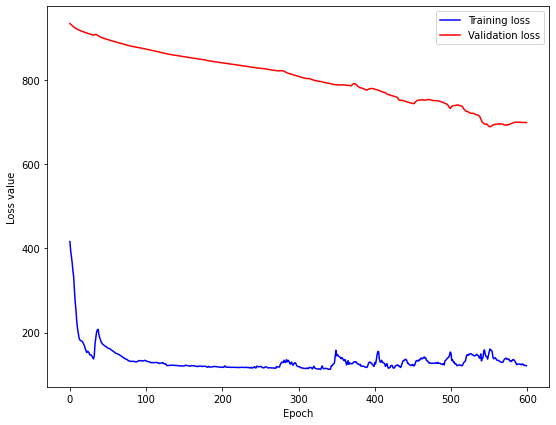

In [19]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [20]:
# Creating the final model 
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, n_ft)))
model.add(Dense(1))

# Initiating the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

# Fitting the model
history = model.fit(X, Y, epochs=epochs, batch_size=batch, shuffle=False)

Epoch 1/600
4/4 [==============================] - 0s 6ms/step - loss: 408.4284
Epoch 2/600
4/4 [==============================] - 0s 5ms/step - loss: 402.4992
Epoch 3/600
4/4 [==============================] - 0s 4ms/step - loss: 395.5366
Epoch 4/600
4/4 [==============================] - 0s 4ms/step - loss: 392.3697
Epoch 5/600
4/4 [==============================] - 0s 5ms/step - loss: 391.7123
Epoch 6/600
4/4 [==============================] - 0s 5ms/step - loss: 388.0699
Epoch 7/600
4/4 [==============================] - 0s 4ms/step - loss: 386.6353
Epoch 8/600
4/4 [==============================] - 0s 4ms/step - loss: 384.7220
Epoch 9/600
4/4 [==============================] - 0s 5ms/step - loss: 381.1792
Epoch 10/600
4/4 [==============================] - 0s 6ms/step - loss: 377.4701
Epoch 11/600
4/4 [==============================] - 0s 5ms/step - loss: 373.5907
Epoch 12/600
4/4 [==============================] - 0s 4ms/step - loss: 369.5236
Epoch 13/600
4/4 [===================

4/4 [==============================] - 0s 4ms/step - loss: 75.6521
Epoch 103/600
4/4 [==============================] - 0s 5ms/step - loss: 69.0799
Epoch 104/600
4/4 [==============================] - 0s 5ms/step - loss: 66.3646
Epoch 105/600
4/4 [==============================] - 0s 4ms/step - loss: 65.5622
Epoch 106/600
4/4 [==============================] - 0s 5ms/step - loss: 64.6202
Epoch 107/600
4/4 [==============================] - 0s 5ms/step - loss: 63.9865
Epoch 108/600
4/4 [==============================] - 0s 5ms/step - loss: 63.0203
Epoch 109/600
4/4 [==============================] - 0s 4ms/step - loss: 62.4270
Epoch 110/600
4/4 [==============================] - 0s 4ms/step - loss: 62.1439
Epoch 111/600
4/4 [==============================] - 0s 4ms/step - loss: 62.6032
Epoch 112/600
4/4 [==============================] - 0s 4ms/step - loss: 63.3345
Epoch 113/600
4/4 [==============================] - 0s 5ms/step - loss: 62.8618
Epoch 114/600
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 54.4430
Epoch 204/600
4/4 [==============================] - 0s 5ms/step - loss: 55.5403
Epoch 205/600
4/4 [==============================] - 0s 5ms/step - loss: 55.0911
Epoch 206/600
4/4 [==============================] - 0s 6ms/step - loss: 55.0588
Epoch 207/600
4/4 [==============================] - 0s 5ms/step - loss: 55.8383
Epoch 208/600
4/4 [==============================] - 0s 6ms/step - loss: 54.6023
Epoch 209/600
4/4 [==============================] - 0s 5ms/step - loss: 55.1650
Epoch 210/600
4/4 [==============================] - 0s 5ms/step - loss: 54.8775
Epoch 211/600
4/4 [==============================] - 0s 4ms/step - loss: 54.9207
Epoch 212/600
4/4 [==============================] - 0s 5ms/step - loss: 54.8697
Epoch 213/600
4/4 [==============================] - 0s 5ms/step - loss: 55.1593
Epoch 214/600
4/4 [==============================] - 0s 5ms/step - loss: 54.8000
Epoch 215/600
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 68.5366
Epoch 305/600
4/4 [==============================] - 0s 4ms/step - loss: 67.0852
Epoch 306/600
4/4 [==============================] - 0s 5ms/step - loss: 67.0723
Epoch 307/600
4/4 [==============================] - 0s 5ms/step - loss: 66.9706
Epoch 308/600
4/4 [==============================] - 0s 5ms/step - loss: 61.7610
Epoch 309/600
4/4 [==============================] - 0s 5ms/step - loss: 68.9597
Epoch 310/600
4/4 [==============================] - 0s 5ms/step - loss: 67.8020
Epoch 311/600
4/4 [==============================] - 0s 4ms/step - loss: 65.4572
Epoch 312/600
4/4 [==============================] - 0s 4ms/step - loss: 70.3918
Epoch 313/600
4/4 [==============================] - 0s 5ms/step - loss: 64.6675
Epoch 314/600
4/4 [==============================] - 0s 4ms/step - loss: 62.7457
Epoch 315/600
4/4 [==============================] - 0s 5ms/step - loss: 62.4515
Epoch 316/600
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 56.9157
Epoch 406/600
4/4 [==============================] - 0s 4ms/step - loss: 56.8211
Epoch 407/600
4/4 [==============================] - 0s 5ms/step - loss: 56.7578
Epoch 408/600
4/4 [==============================] - 0s 5ms/step - loss: 56.6348
Epoch 409/600
4/4 [==============================] - 0s 5ms/step - loss: 56.5716
Epoch 410/600
4/4 [==============================] - 0s 5ms/step - loss: 56.4358
Epoch 411/600
4/4 [==============================] - 0s 5ms/step - loss: 56.3228
Epoch 412/600
4/4 [==============================] - 0s 5ms/step - loss: 56.1856
Epoch 413/600
4/4 [==============================] - 0s 4ms/step - loss: 56.1652
Epoch 414/600
4/4 [==============================] - 0s 4ms/step - loss: 56.0239
Epoch 415/600
4/4 [==============================] - 0s 4ms/step - loss: 55.9428
Epoch 416/600
4/4 [==============================] - 0s 6ms/step - loss: 55.7686
Epoch 417/600
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 49.7812
Epoch 507/600
4/4 [==============================] - 0s 6ms/step - loss: 49.7176
Epoch 508/600
4/4 [==============================] - 0s 4ms/step - loss: 49.6767
Epoch 509/600
4/4 [==============================] - 0s 5ms/step - loss: 49.6080
Epoch 510/600
4/4 [==============================] - 0s 5ms/step - loss: 49.6010
Epoch 511/600
4/4 [==============================] - 0s 5ms/step - loss: 49.5802
Epoch 512/600
4/4 [==============================] - 0s 4ms/step - loss: 49.5237
Epoch 513/600
4/4 [==============================] - 0s 5ms/step - loss: 49.4949
Epoch 514/600
4/4 [==============================] - 0s 6ms/step - loss: 49.4139
Epoch 515/600
4/4 [==============================] - 0s 6ms/step - loss: 49.4172
Epoch 516/600
4/4 [==============================] - 0s 4ms/step - loss: 49.3619
Epoch 517/600
4/4 [==============================] - 0s 4ms/step - loss: 49.3540
Epoch 518/600
4/4 [=======================

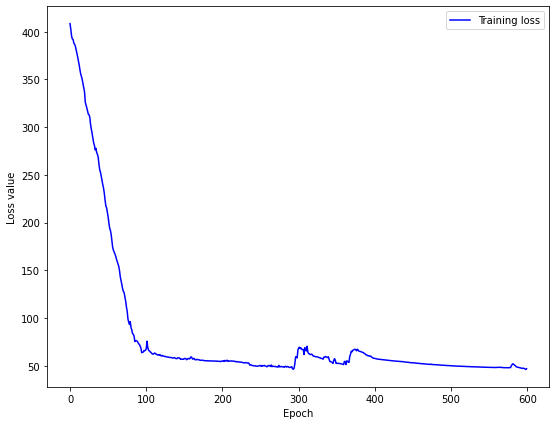

In [21]:
mse = history.history.get('loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [22]:
# Getting the newest data 
Ynew = Yts[-n_lag:]

# Reshaping for the model input 
Ynew = np.reshape(Ynew, (1, n_lag, n_ft))

print(f'Shape of the input for prediction: {Ynew.shape}')

Shape of the input for prediction: (1, 14, 209)


In [23]:
yhat = model.predict(Ynew)[0]
print(f'Prediction: {yhat}')

Prediction: [1297.867]


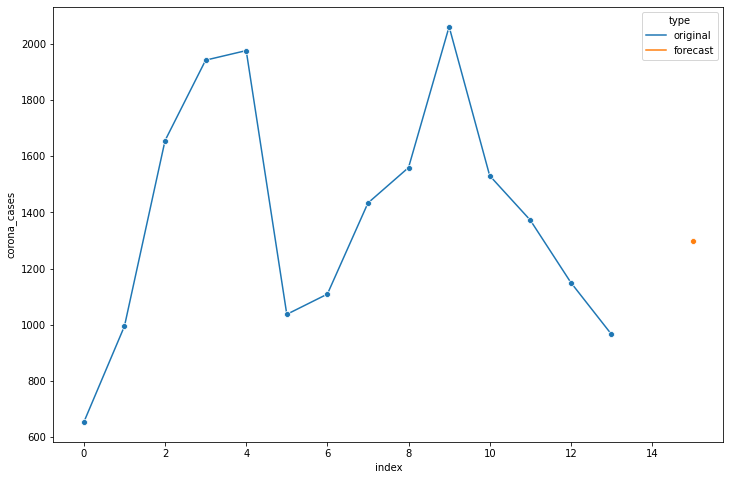

In [24]:
# Visualizing the prediction 
dorig = pd.DataFrame({'index': range(n_lag), 'corona_cases': Y[-n_lag:], 'type': 'original'})
dfc = pd.DataFrame({'index': n_lag + 1, 'corona_cases': yhat[0], 'type': 'forecast'}, index=[0])

dplot = pd.concat([dorig, dfc], axis=0)
plt.figure(figsize=(12, 8))
sns.lineplot(x='index', y='corona_cases', data=dplot, hue='type', marker='o')
plt.show()